<h3> Script to show the result of the Evaluation metrics </h3>

<p> Here we visualize the effect of the incremental deletion metric. <br> We explain a prediction of ResNet with RISE and delete pixels in the order of relevance given by RISE. <br> from there we measure the confidences and visualize how this deletion influences the model score. </p>

In [1]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import numpy as np
from relevance_maps_properties.metrics.metrics import Incremental_deletion
from pathlib import Path
# keras model and preprocessing tools
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K
from keras import utils
# dianna library for explanation
import dianna
from dianna import visualization
from dianna.utils import get_function
from tqdm import tqdm
# for plotting
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x, verbose=0)

model = Model()

In [3]:
def load_img(path):
    img = utils.load_img(path, target_size=model.input_size)
    x = utils.img_to_array(img)
    x = preprocess_input(x)
    return img, x

def to_img(x):
    z = np.copy(x) # IMPORTANT TO SEPERATE ARRAYS IN MEMORY
    z = preprocess_input(z)
    img = utils.array_to_img(z)
    return img

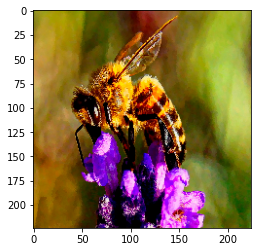

In [4]:
img, x = load_img(Path('.', 'bee.jpg'))
plt.imshow(img)


In [5]:
relevances = dianna.explain_image(model.run_on_batch, x, method="RISE",
                                labels=[i for i in range(1000)],
                                n_masks=1000, feature_res=6, p_keep=.1,
                                axis_labels={2: 'channels'})

Explaining: 100%|██████████| 10/10 [01:00<00:00,  6.06s/it]


<h5> Visualize the explanation for the predicted label </h5>

1/1 [==============================] - 0s 72ms/step
Explanation for `bee`


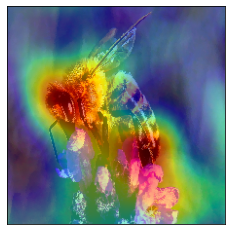

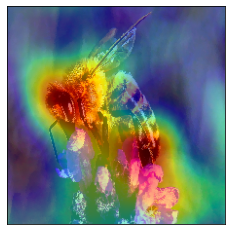

In [6]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

gold_lbl = np.argmax(model.model.predict(x[None, ...]))
expl = relevances[gold_lbl]

print(f'Explanation for `{class_name(gold_lbl)}`')
visualization.plot_image(expl, utils.img_to_array(img) / 255., heatmap_cmap='jet')

In [7]:
def generate_examples(x, inds, impute, nremove=5500):
    ''' 
    Helper function to generate examples for removing pixels.
    '''
    imgs = []
    preds = []
    removed = []

    z = np.copy(x)
    for k in range(0, nremove * 5, nremove):
        for i, j in inds[:k]:
            z[i, j, ...] = impute

        pred = np.max(model.model.predict(z[None, ...]), axis=0)[gold_lbl]
        preds.append(pred)
        imgs.append(to_img(z))
        removed.append(k)

    return imgs, preds, removed

In [8]:
inds = np.stack(np.unravel_index(np.argsort(expl, axis=None), expl.shape), axis=1)[::-1] # Get indices after sorting relevances
channel_mean = np.mean(x, axis=(0,1))

_, x = load_img(Path('.', 'bee.jpg'))
imgs, preds, nremoved = generate_examples(x, inds, channel_mean)

# Remove at random
_, x = load_img(Path('.', 'bee.jpg'))
np.random.shuffle(inds)
rand_imgs, rand_preds, nremoved = generate_examples(x, inds, channel_mean)

1/1 [==============================] - 0s 73ms/step


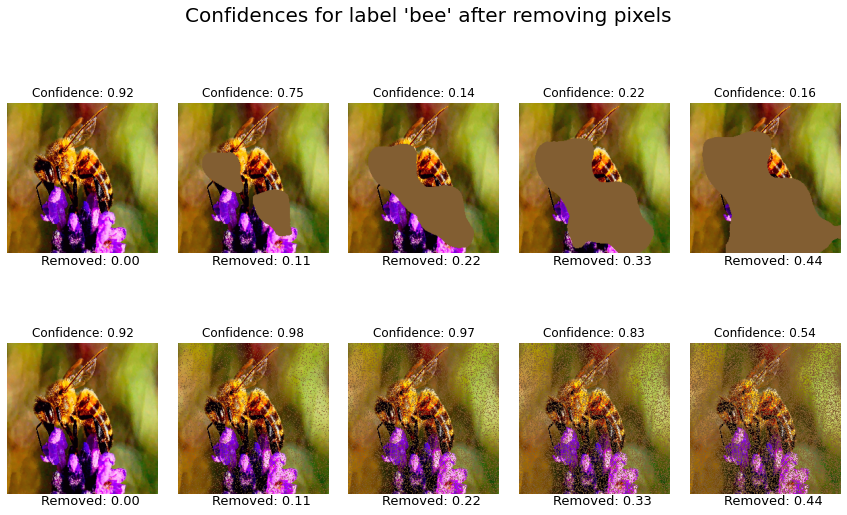

In [9]:
# Visualize the examples
npixels = x.shape[0] * x.shape[1]
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))

for i, (img, rand_img, removed) in enumerate(zip(imgs, rand_imgs, nremoved)):
    col = axes[:,i]

    for a in col:
        a.text(50, 240, 'Removed: {:.2f}'.format(removed / npixels), fontsize=13)
        a.axis('off')

    col[0].set_title("Confidence: {:.2f}".format(preds[i]))
    col[0].imshow(img)
    col[1].set_title("Confidence: {:.2f}".format(rand_preds[i]))
    col[1].imshow(rand_img)

fig.suptitle("Confidences for label 'bee' after removing pixels", size=20)
fig.tight_layout()
plt.show()

In [10]:
from typing import Callable, Any, Optional, Union
from nptyping import NDArray

deleter = Incremental_deletion(model.model.predict, 448)

# scores = deleter.batched_evaluate(x, expl, 10, verbose=0)
scores = deleter.evaluate(x, expl, batch_size=10, verbose=0)
scores

Evaluating: 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


array([9.24659371e-001, 8.80944610e-001, 8.29163373e-001, 7.99514174e-001,
       8.52069676e-001, 8.56094599e-001, 8.82797837e-001, 8.93035650e-001,
       8.24917316e-001, 8.18697691e-001, 8.46982837e-001, 8.06696057e-001,
       7.04315662e-001, 4.35617208e-001, 2.86497474e-001, 1.72229886e-001,
       2.02615321e-001, 3.94127220e-001, 3.11296552e-001, 2.13944659e-001,
       3.69410902e-001, 4.66552615e-001, 4.96541649e-001, 1.56321540e-001,
       9.20918658e-002, 1.17247343e-001, 8.36422816e-002, 1.00638367e-001,
       3.29337180e-001, 1.93227008e-001, 1.91676199e-001, 2.12373823e-001,
       2.36695632e-001, 1.63432762e-001, 1.66416436e-001, 2.27290735e-001,
       2.19118059e-001, 2.14917153e-001, 2.85827756e-001, 3.07242692e-001,
       9.97423232e-002, 1.89889908e-001, 2.24390581e-001, 1.23213187e-001,
       1.61033317e-001, 3.06756824e-001, 1.84850067e-001, 2.21341655e-001,
       1.92475572e-001, 9.27811489e-002, 1.37588292e-001, 1.21690638e-001,
       1.38075501e-001, 1

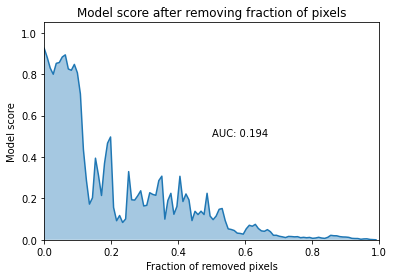

In [11]:
deleter.visualize(scores)
